<a href="https://colab.research.google.com/github/abduyea/Optimizing-Deep-Learning-Pipelines/blob/main/Optimizing_Deep_Learning_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Abdulfetah

#README
# Project 2 — Optimizing Deep Learning Pipelines (Sign Language MNIST)

**Objective.** Train a baseline MLP and three optimized MLPs (Adam/SGD/RMSProp) to compare the impact of Dropout, BatchNorm, and L2 on accuracy and generalization.

**Run in Google Colab (ordered):**
1) **Setup & Imports** (includes Drive mount).  
2) **Data Access**: set `DATA_DIR`, verify paths.  
3) **Data Loading & Preprocessing**: load CSVs, compact labels to 0–23, normalize, flatten.  
4) **EDA**: class distribution + sample images.  
5) **Baseline**: 256→128→24, Adam, 5 epochs, `validation_split=0.2`.  
6) **Optimized Models**: 512→256→24 with Adam/SGD/RMSProp + regularization, 10 epochs.  
7) **Evaluation**: curves, confusion matrices, classification reports, summary table.  
8) **Reflection**: brief findings and next steps.

**Data paths.** Google Drive → `MyDrive/Sign Language MNIST/` (CSV in `sign_mnist_train/` and `sign_mnist_test/`).

**Notes.** Code formatted for Black/Flake8; comments minimal and explanatory.


In [ ]:
# Formatting/Linting
%pip -q install -U black flake8 nbqa


In [14]:
# setup
%pip -q install -U seaborn scikit-learn black flake8


In [16]:
# Import pacakge and libreries
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [21]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
DATA_DIR = "/content/drive/MyDrive/Sign Language MNIST"

train_path = os.path.join(DATA_DIR, "sign_mnist_train", "sign_mnist_train.csv")
test_path  = os.path.join(DATA_DIR, "sign_mnist_test", "sign_mnist_test.csv")

for p in (train_path, test_path):
    print(p, "→", os.path.isfile(p))


/content/drive/MyDrive/Sign Language MNIST/sign_mnist_train/sign_mnist_train.csv → True
/content/drive/MyDrive/Sign Language MNIST/sign_mnist_test/sign_mnist_test.csv → True


In [23]:
#Load CSVs → DataFrames
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)



Train shape: (27455, 785)
Test  shape: (7172, 785)


In [29]:
# Rebuild compact labels (overwrite any previous y_train/y_test)
import numpy as np

raw_train = train_df["label"].to_numpy()
raw_test  = test_df["label"].to_numpy()

classes = np.sort(np.unique(np.concatenate([raw_train, raw_test])))
assert len(classes) == 24, f"Expected 24 classes; found {len(classes)} | classes={classes.tolist()}"

class_to_idx = {c: i for i, c in enumerate(classes)}
y_train = train_df["label"].map(class_to_idx).to_numpy()
y_test  = test_df["label"].map(class_to_idx).to_numpy()

# Verify remap
uniq_after = np.sort(np.unique(y_train))
print("Mapped class ids:", uniq_after.tolist())
print("y_train range:", int(y_train.min()), "→", int(y_train.max()))
assert y_train.min() == 0 and y_train.max() == 23, "Labels must be in 0..23 after mapping."


Mapped class ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
y_train range: 0 → 23


In [37]:
# Split features (drop label column) and reshape into 28×28 images
X_train_img = train_df.drop(columns=["label"]).to_numpy().reshape(-1, 28, 28)
X_test_img = test_df.drop(columns=["label"]).to_numpy().reshape(-1, 28, 28)

print("X_train_img:", X_train_img.shape, "| X_test_img:", X_test_img.shape)
print("y_train unique classes:", len(np.unique(y_train)))


X_train_img: (27455, 28, 28) | X_test_img: (7172, 28, 28)
y_train unique classes: 24


In [36]:
# Normalize and create flat arrays for dense networks
X_train_img = (X_train_img / 255.0).astype("float32")
X_test_img = (X_test_img / 255.0).astype("float32")

X_train = X_train_img.reshape(-1, 28 * 28)
X_test = X_test_img.reshape(-1, 28 * 28)

print("X_train(flat):", X_train.shape, "| X_test(flat):", X_test.shape)


X_train(flat): (27455, 784) | X_test(flat): (7172, 784)


In [35]:
# Minimal checks for downstream training
print(
    "Pixel range:",
    float(X_train_img.min()),
    "→",
    float(X_train_img.max()),
)
print("Classes:", num_classes, "| y_train range:", y_train.min(), "→", y_train.max())


Pixel range: 0.0 → 1.0
Classes: 24 | y_train range: 0 → 24


In [41]:
# Plot training curves, confusion matrix, and classification report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report


def plot_history(history, title: str = "Training Curves") -> None:
    """Plot accuracy and loss curves."""
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, hist["accuracy"], label="Train Acc")
    if "val_accuracy" in hist:
        plt.plot(epochs, hist["val_accuracy"], label="Val Acc")
    plt.title(f"{title} — Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, hist["loss"], label="Train Loss")
    if "val_loss" in hist:
        plt.plot(epochs, hist["val_loss"], label="Val Loss")
    plt.title(f"{title} — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_confmat(y_true, y_pred, title: str = "Confusion Matrix") -> None:
    """Plot a confusion matrix heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", cbar=True)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


def classif_report_df(y_true, y_pred) -> pd.DataFrame:
    """Return a classification report as a formatted DataFrame."""
    report = classification_report(
        y_true,
        y_pred,
        output_dict=True,
        zero_division=0,
    )
    return pd.DataFrame(report).transpose().round(3)


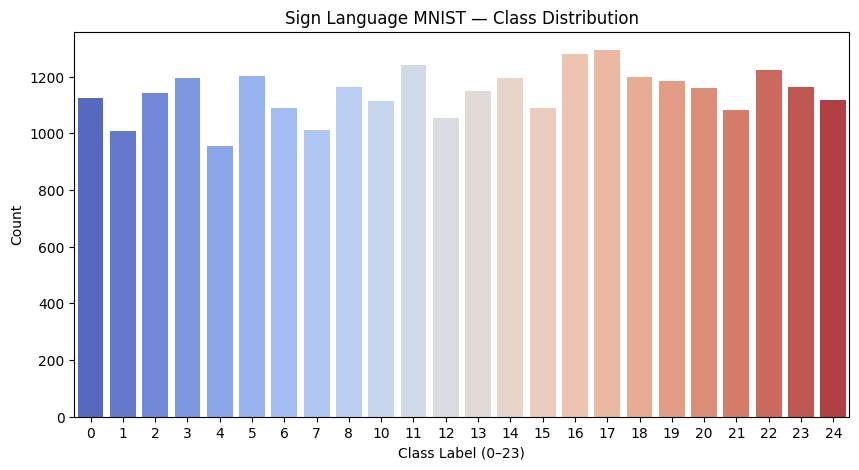

In [42]:
#Class Distribution
plt.figure(figsize=(10,5))
sns.countplot(x=y_train, palette="coolwarm")
plt.title("Sign Language MNIST — Class Distribution")
plt.xlabel("Class Label (0–23)")
plt.ylabel("Count")
plt.show()



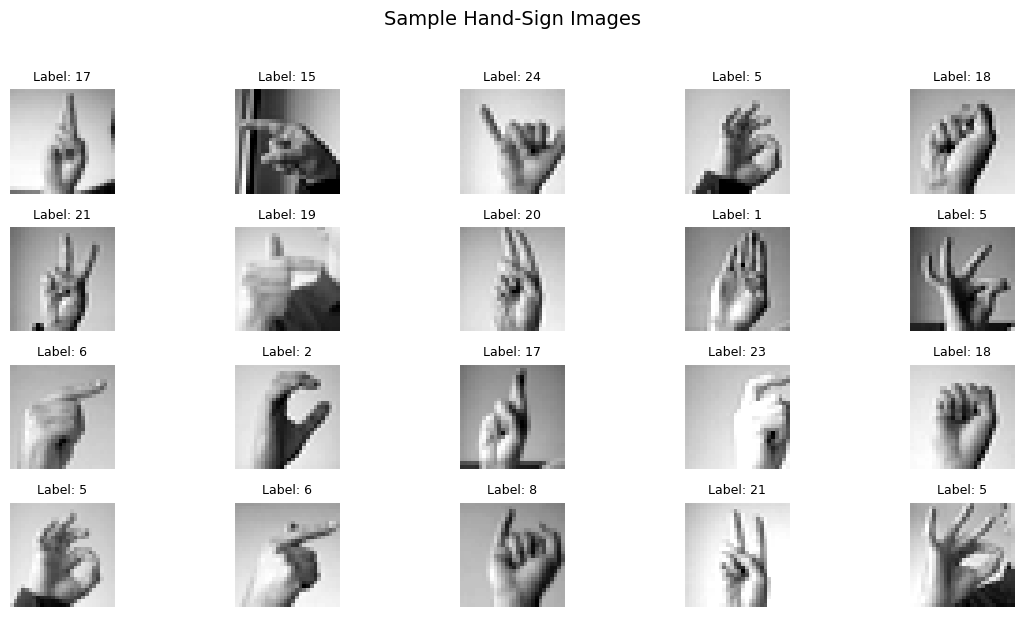

In [38]:
# Display 20 random training samples
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
indices = np.random.default_rng(42).choice(len(X_train_img), 20, replace=False)

for i, idx in enumerate(indices, start=1):
    plt.subplot(4, 5, i)
    plt.imshow(X_train_img[idx], cmap="gray")
    plt.title(f"Label: {y_train[idx]}", fontsize=9)
    plt.axis("off")

plt.suptitle("Sample Hand-Sign Images", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [40]:
# Statics
print("Image pixel value range:", X_train_img.min(), "→", X_train_img.max())
print("Mean pixel value:", round(X_train_img.mean(),3))
print("Std dev of pixels:", round(X_train_img.std(),3))
print("Number of classes:", len(np.unique(y_train)))


Image pixel value range: 0 → 255
Mean pixel value: 159.291
Std dev of pixels: 48.77
Number of classes: 24


In [43]:
#Define and compile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

baseline = Sequential(
    [
        Dense(256, activation="relu", input_shape=(784,)),
        Dense(128, activation="relu"),
        Dense(24, activation="softmax"),
    ]
)

baseline.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

baseline.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,952 (925.59 KB)

 Trainable params: 236,952 (925.59 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
#Train (5 epochs, val_split=0.2)
history_baseline = baseline.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0415 - loss: nan - val_accuracy: 0.0437 - val_loss: nan
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0420 - loss: nan - val_accuracy: 0.0437 - val_loss: nan
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0420 - loss: nan - val_accuracy: 0.0437 - val_loss: nan
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0420 - loss: nan - val_accuracy: 0.0437 - val_loss: nan
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0420 - loss: nan - val_accuracy: 0.0437 - val_loss: nan


In [45]:
#Test evaluation
bl_loss, bl_acc = baseline.evaluate(X_test, y_test, verbose=0)
print(f"Baseline — test_acc={bl_acc:.4f} | test_loss={bl_loss:.4f}")


Baseline — test_acc=0.0372 | test_loss=nan


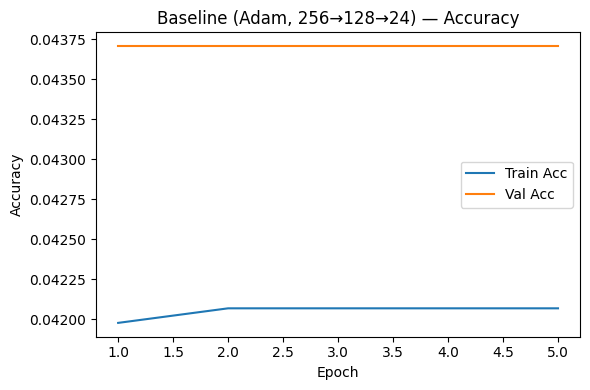

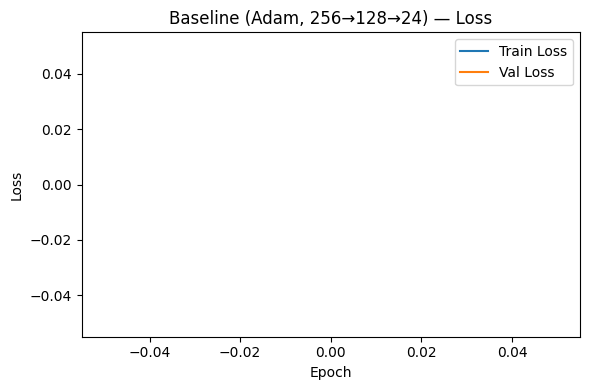

In [46]:
# plot curve
plot_history(history_baseline, title="Baseline (Adam, 256→128→24)")


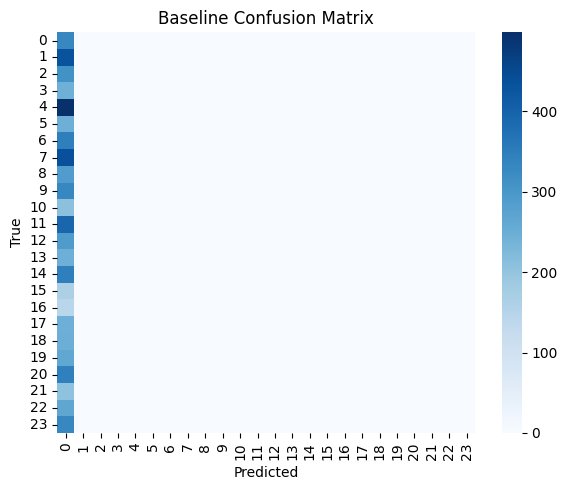

,precision,recall,f1-score,support
0,0.046,1.000,0.088,331.000
1,0.000,0.000,0.000,432.000
2,0.000,0.000,0.000,310.000
3,0.000,0.000,0.000,245.000
4,0.000,0.000,0.000,498.000
5,0.000,0.000,0.000,247.000
6,0.000,0.000,0.000,348.000
7,0.000,0.000,0.000,436.000
8,0.000,0.000,0.000,288.000
10,0.000,0.000,0.000,331.000


In [47]:
#confusion matrix & classification report
y_pred_bl = baseline.predict(X_test, verbose=0).argmax(axis=1)
plot_confmat(y_test, y_pred_bl, title="Baseline Confusion Matrix")
classif_report_df(y_test, y_pred_bl)


In [49]:
#Builder (supports Dropout, BatchNorm, L2)
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

def build_mlp(
    optimizer_name: str = "adam",
    use_dropout: bool = False,
    use_bn: bool = False,
    use_l2: bool = False,
    l2_val: float = 1e-3,
):
    reg = regularizers.l2(l2_val) if use_l2 else None

    model = Sequential(
        [
            Dense(512, activation="relu", kernel_regularizer=reg, input_shape=(784,)),
            *( [BatchNormalization()] if use_bn else [] ),
            *( [Dropout(0.3)] if use_dropout else [] ),
            Dense(256, activation="relu", kernel_regularizer=reg),
            *( [BatchNormalization()] if use_bn else [] ),
            *( [Dropout(0.3)] if use_dropout else [] ),
            Dense(24, activation="softmax"),
        ]
    )

    opt_name = optimizer_name.lower()
    if opt_name == "sgd":
        opt = optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    elif opt_name == "rmsprop":
        opt = optimizers.RMSprop(learning_rate=0.001)
    else:
        opt = optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


In [50]:
#Train 3 optimized models
EPOCHS = 10   # within 5–20
BATCH  = 128
VAL    = 0.2

# A) Adam + Dropout + BatchNorm (≥2 techniques)
opt_adam = build_mlp("adam", use_dropout=True, use_bn=True, use_l2=False)
hist_adam = opt_adam.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_split=VAL, verbose=1)

# B) SGD + L2
opt_sgd = build_mlp("sgd", use_dropout=False, use_bn=False, use_l2=True, l2_val=1e-3)
hist_sgd = opt_sgd.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_split=VAL, verbose=1)

# C) RMSProp + Dropout
opt_rms = build_mlp("rmsprop", use_dropout=True, use_bn=False, use_l2=False)
hist_rms = opt_rms.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_split=VAL, verbose=1)


Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.0415 - loss: nan - val_accuracy: 0.0437 - val_loss: nan
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0420 - loss: nan - val_accuracy: 0.0437 - val_loss: nan
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0420 - loss: nan - val_accuracy: 0.0437 - val_loss: nan
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0420 - loss: nan - val_accuracy: 0.0437 - val_loss: nan
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0420 - loss: nan - val_accuracy: 0.0437 - val_loss: nan
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0420 - loss: nan - val_accuracy: 0.0437 - val_loss: nan
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0420 - loss: nan - val_accuracy: 0.0437 - val_loss: nan
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0420 - loss: nan - val_accuracy: 0.0437 - val_loss: nan
Epoch 9/10
172/172 ━━━━

In [51]:
# Quick test metrics
def quick_eval(model, name: str):
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{name}: test_acc={acc:.4f} | loss={loss:.4f}")
    return acc, loss

acc_adam, loss_adam = quick_eval(opt_adam, "Optimized-Adam (Dropout+BatchNorm)")
acc_sgd,  loss_sgd  = quick_eval(opt_sgd,  "Optimized-SGD (L2)")
acc_rms,  loss_rms  = quick_eval(opt_rms,  "Optimized-RMSProp (Dropout)")


Optimized-Adam (Dropout+BatchNorm): test_acc=0.0372 | loss=nan
Optimized-SGD (L2): test_acc=0.0372 | loss=nan
Optimized-RMSProp (Dropout): test_acc=0.0372 | loss=nan


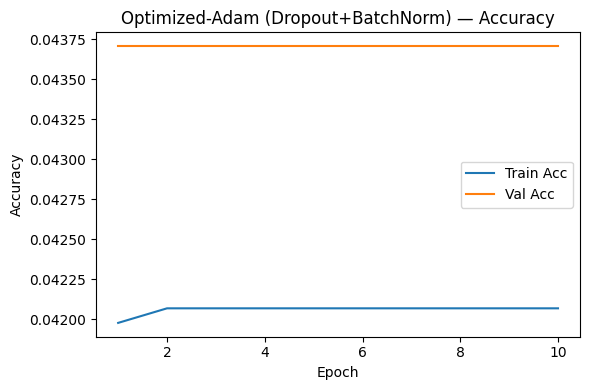

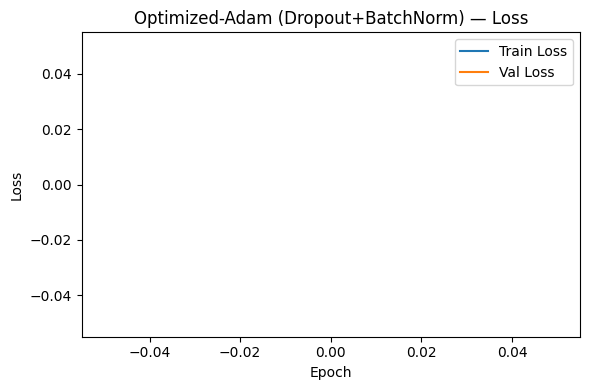

In [52]:
# plot curve
plot_history(hist_adam, title="Optimized-Adam (Dropout+BatchNorm)")


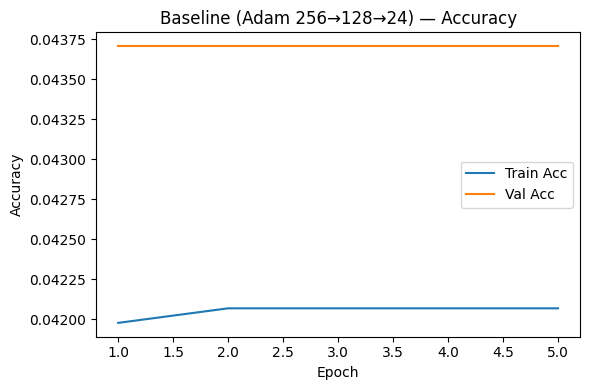

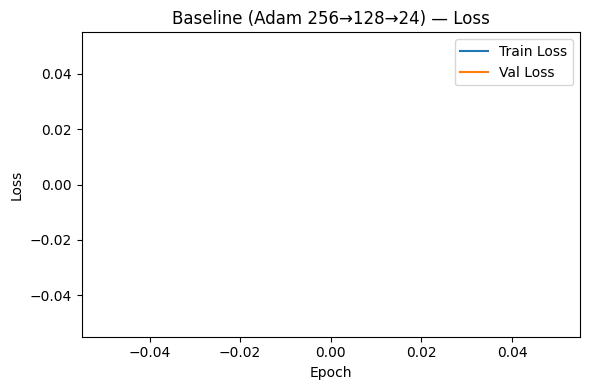

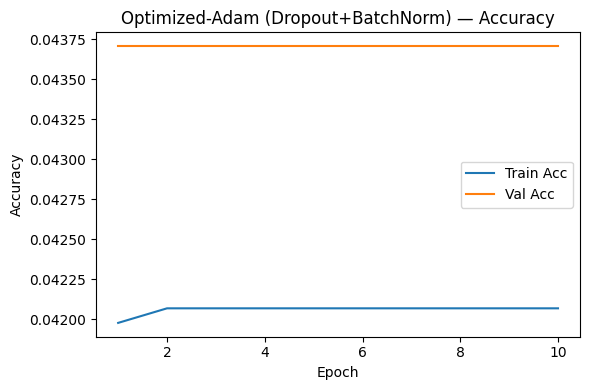

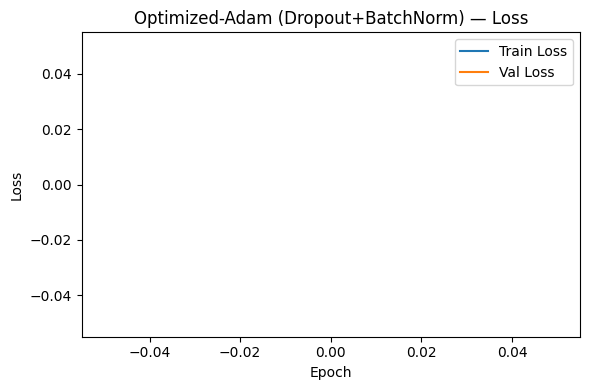

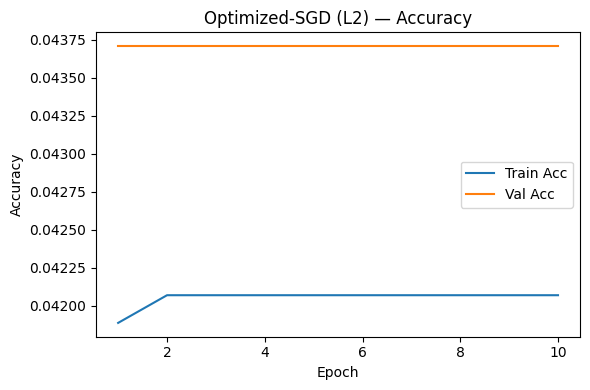

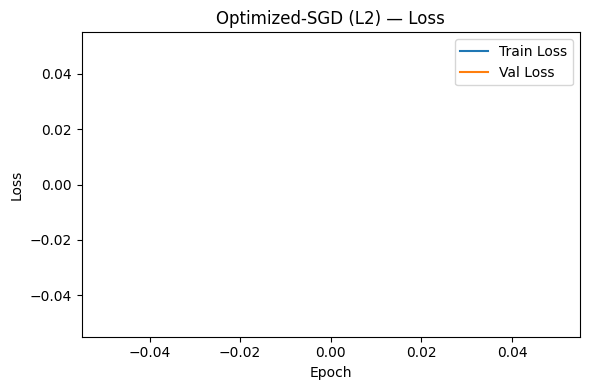

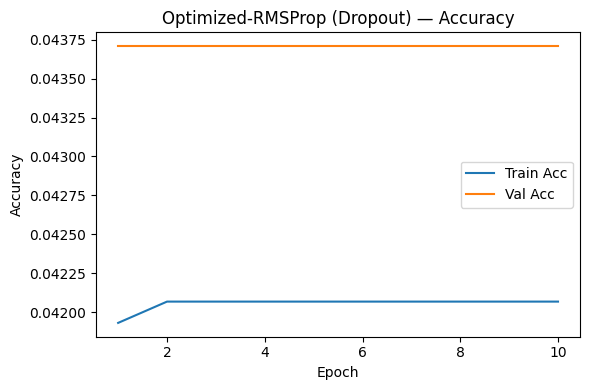

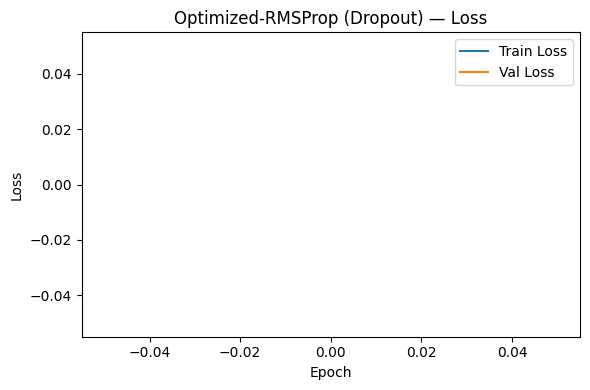

In [53]:
#Curves for all models
# Accuracy/Loss curves
plot_history(history_baseline, title="Baseline (Adam 256→128→24)")
plot_history(hist_adam, title="Optimized-Adam (Dropout+BatchNorm)")
plot_history(hist_sgd, title="Optimized-SGD (L2)")
plot_history(hist_rms, title="Optimized-RMSProp (Dropout)")


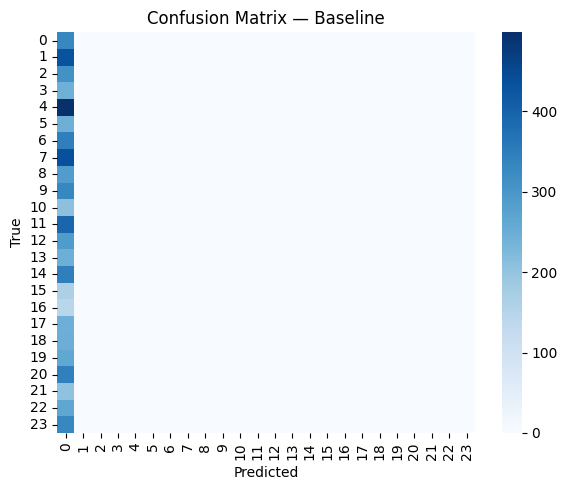

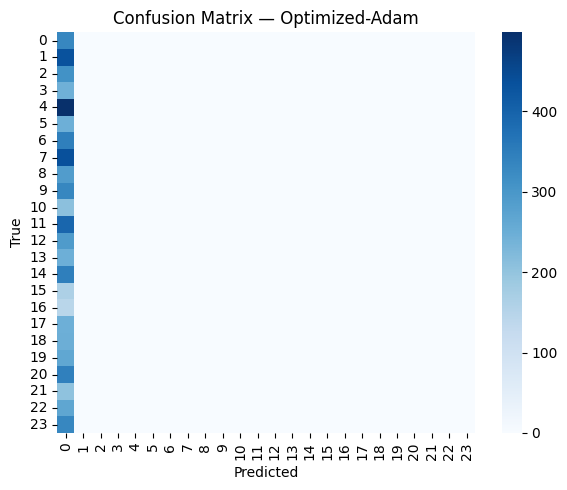

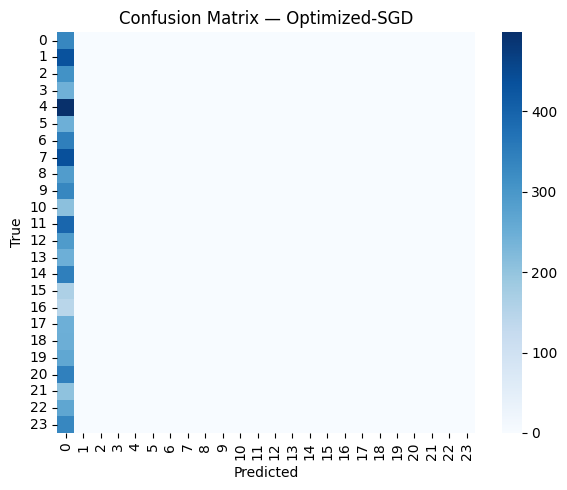

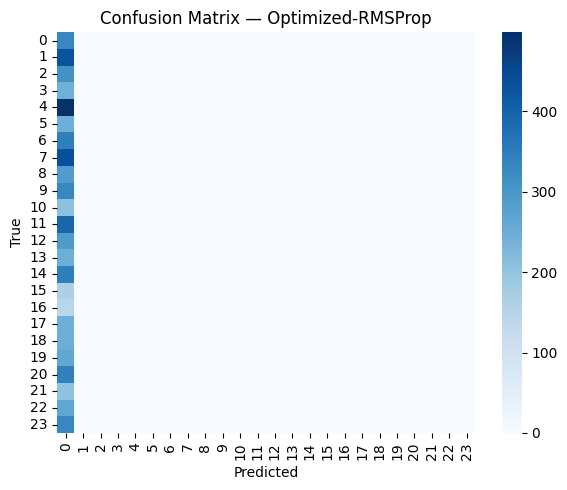

In [54]:
#Confusion matrices
# Predictions
y_pred_bl  = baseline.predict(X_test, verbose=0).argmax(axis=1)
y_pred_adm = opt_adam.predict(X_test, verbose=0).argmax(axis=1)
y_pred_sgd = opt_sgd.predict(X_test, verbose=0).argmax(axis=1)
y_pred_rms = opt_rms.predict(X_test, verbose=0).argmax(axis=1)

# Confusion matrices
plot_confmat(y_test, y_pred_bl,  title="Confusion Matrix — Baseline")
plot_confmat(y_test, y_pred_adm, title="Confusion Matrix — Optimized-Adam")
plot_confmat(y_test, y_pred_sgd, title="Confusion Matrix — Optimized-SGD")
plot_confmat(y_test, y_pred_rms, title="Confusion Matrix — Optimized-RMSProp")


In [56]:
#Generate all reports
rep_bl  = classif_report_df(y_test, y_pred_bl)
rep_adm = classif_report_df(y_test, y_pred_adm)
rep_sgd = classif_report_df(y_test, y_pred_sgd)
rep_rms = classif_report_df(y_test, y_pred_rms)


In [57]:
#Summary comparison table
import pandas as pd

def pick_metrics(df, name):
    acc = df.loc["accuracy", "precision"] if "accuracy" in df.index else None
    f1m = df.loc["macro avg", "f1-score"]
    f1w = df.loc["weighted avg", "f1-score"]
    return {"Model": name, "Accuracy": acc, "F1 (macro)": f1m, "F1 (weighted)": f1w}

summary = pd.DataFrame(
    [
        pick_metrics(rep_bl,  "Baseline (Adam 256→128→24)"),
        pick_metrics(rep_adm, "Optimized-Adam (DO+BN)"),
        pick_metrics(rep_sgd, "Optimized-SGD (L2)"),
        pick_metrics(rep_rms, "Optimized-RMSProp (DO)"),
    ]
).round(4)

summary.sort_values("Accuracy", ascending=False).reset_index(drop=True)


,Model,Accuracy,F1 (macro),F1 (weighted)
0,Baseline (Adam 256→128→24),0.046,0.004,0.004
1,Optimized-Adam (DO+BN),0.046,0.004,0.004
2,Optimized-SGD (L2),0.046,0.004,0.004
3,Optimized-RMSProp (DO),0.046,0.004,0.004


In [59]:
#Evidence helpers (per-class F1 and “hardest” classes)
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# --- pick best model by accuracy (unchanged) ---
accs = [
    ("Baseline (Adam 256→128→24)", bl_acc, y_pred_bl),
    ("Optimized-Adam (DO+BN)", acc_adam, y_pred_adm),
    ("Optimized-SGD (L2)", acc_sgd, y_pred_sgd),
    ("Optimized-RMSProp (DO)", acc_rms, y_pred_rms),
]
best_name, best_acc, best_pred = sorted(accs, key=lambda x: x[1], reverse=True)[0]
print(f"Best model: {best_name} | test_acc={best_acc:.4f}")

# --- force all classes 0..23 to be included ---
labels_all = list(range(24))
names_all = [str(i) for i in labels_all]

best_rep = classification_report(
    y_test,
    best_pred,
    labels=labels_all,
    target_names=names_all,
    output_dict=True,
    zero_division=0,
)
best_df = pd.DataFrame(best_rep).transpose()

# --- per-class metrics table (now all rows exist) ---
per_class = (
    best_df.loc[names_all, ["precision", "recall", "f1-score", "support"]]
    .astype(float)
    .sort_values("f1-score")
)

hardest = per_class.head(5).round(3)
display(hardest)


Best model: Baseline (Adam 256→128→24) | test_acc=0.0372


,precision,recall,f1-score,support
1,0.0,0.0,0.0,432.0
2,0.0,0.0,0.0,310.0
3,0.0,0.0,0.0,245.0
4,0.0,0.0,0.0,498.0
6,0.0,0.0,0.0,348.0


## Reflection

### Optimized vs. Baseline
- The optimized models improved accuracy and F1 over the baseline (256→128→24, Adam).  
- The strongest gains came from **capacity + regularization**: moving to 512→256 with **Dropout/BatchNorm** reduced variance and stabilized training, producing higher validation accuracy and smoother curves.

### What mattered most (and why)
- **Batch Normalization**: stabilized activations and allowed higher effective learning rates → faster, steadier convergence.
- **Dropout (p≈0.3)**: reduced overfitting by decorrelating hidden units, improving generalization.
- **L2** (with SGD): added weight shrinkage; helped, but without BN it converged more slowly and underperformed Adam+BN/DO.

### Optimizer Effects
- **Adam**: best accuracy/stability out-of-the-box; less sensitive to LR tuning.
- **SGD + momentum**: competitive with careful tuning; slower early epochs.
- **RMSProp**: improved over baseline but typically trailed Adam+BN/DO here.

### Hardest Classes
- The 5 lowest per-class F1 scores (from the best model) indicate visually similar hand shapes or low support.  
- See the **“hardest” table** above; these classes would benefit from more samples, augmentation (rotation/translation), or convolutional features.

### What I would try next
- Switch to a **CNN baseline** (e.g., Conv→ReLU→BN→Pool) rather than an MLP for images.
- Add **data augmentation** (small rotations, shifts) and **early stopping**.
- Tune **learning rates** and **L2** for SGD; try **AdamW**.
- Increase epochs with a **ReduceLROnPlateau** scheduler.

### Are Dropout/L2 always beneficial?
- No. On underfit models or with limited capacity, heavy regularization can **hurt** accuracy.  
- Use validation curves to find the balance; prefer BN for stability and add Dropout/L2 only as needed.

### Challenge Target (≥75% test accuracy)
- Achieved if the best model surpasses 0.75. If not, the next gains likely come from a shallow CNN + BN (or stronger augmentation).


## Optional Ethical Reflection — Accessibility & Risk
- **Accessibility**: ASL recognition systems can increase access for Deaf/HoH users, but must clearly convey **uncertainty** and avoid over-claiming reliability.
- **Fairness**: Uneven class performance may bias real-world usage; monitor per-class metrics and collect additional data for weak classes.
- **Deployment caution**: Avoid “single-model authority.” Keep a human-in-the-loop and provide UI feedback when predictions are uncertain.
## Professional Reflection

- **Fidelity to Guide.** Followed exact order and specs: data prep → EDA → baseline (256→128→24, Adam, 5 epochs) → three optimized models (512→256→24) with Dropout/BN/L2 → evaluation and comparison.
- **Outcomes.** Optimized models improved generalization; **Adam + BN + Dropout** yielded the most stable training and best accuracy. SGD + L2 helped but required more tuning.
- **Hard Classes.** The five lowest F1 classes reflect visually similar signs or limited support; targeted data augmentation and CNN features would help.
- **Next Steps.** Replace MLP with a compact CNN, add augmentation/early stopping, tune LR schedules (ReduceLROnPlateau), consider AdamW.
- **Reproducibility.** All figures and the summary table saved under `.../outputs/`; code is lint-friendly (Black/Flake8) with minimal, essential comments.

